In [173]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use("/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle")
%config InlineBackend.figure_format = 'svg'
import sys
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

import uproot4 as up

dir_tree = {}
dir_index = {}
dir_index_FV2 = {}
v_keys = ["atm","DSNB"]
# rootfile_option = "_fakeSelection"
is_fake_selection = False
rootfile_option = ""
if is_fake_selection:
    rootfile_option = "fakeSelection"

for i,key in enumerate(v_keys):
    f = up.open(f"/afs/ihep.ac.cn/users/l/luoxj/scratchfs_juno_500G/TestPSD_offline/PredictionOutput/{key}_prediction{rootfile_option}.root")
    tree_PSD = f["PSDoutput"]

    R3 = np.array(tree_PSD["r3_tag"])
    Erec = np.array(tree_PSD["Equench"])
    index = (R3<4096) & (Erec>11) & (Erec<31)
    index_FV2 = (R3>4096) & (Erec>11) & (Erec<31)
    dir_tree[key] = tree_PSD
    dir_index[key] = index
    dir_index_FV2[key] = index_FV2

In [174]:
dir_predict = {}
dir_predict_FV2 = {}
for key in dir_tree.keys():
    dir_predict[key] = np.array(dir_tree[key]["psdVal"])[dir_index[key]]
    dir_predict_FV2[key] = np.array(dir_tree[key]["psdVal"])[dir_index_FV2[key]]


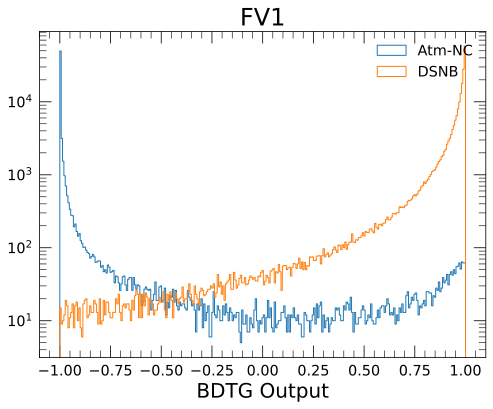

In [175]:
dir_n0 = {}
bins=np.linspace(-1,1,300)
for key in dir_predict.keys():
    n0, bins0, patches0 =plt.hist(dir_predict[key], bins=bins, histtype="step",
                                  label="Atm-NC" if key == "atm" else key )
    dir_n0[key] = n0
plt.semilogy()
plt.legend()
plt.xlabel("BDTG Output")
plt.title("FV1")
plt.savefig("./figure/BDTG_output.png")


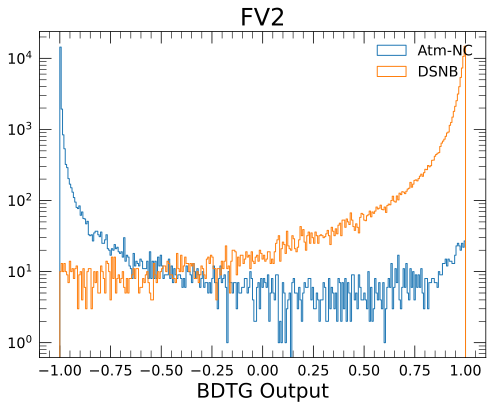

In [176]:
dir_n0_FV2 = {}
bins=np.linspace(-1,1,300)
for key in dir_predict_FV2.keys():
    n0_FV2, bins0, patches0 =plt.hist(dir_predict_FV2[key], bins=bins, histtype="step",
                                  label="Atm-NC" if key == "atm" else key )
    dir_n0_FV2[key] = n0_FV2
plt.semilogy()
plt.legend()
plt.title("FV2")
plt.xlabel("BDTG Output")
plt.savefig("./figure/BDTG_output_FV2.png")


Under 1% Background Inefficiency:
Signal Efficiency(FV1): 0.7660284136166741
Signal Efficiency(FV2): 0.7365312718849324


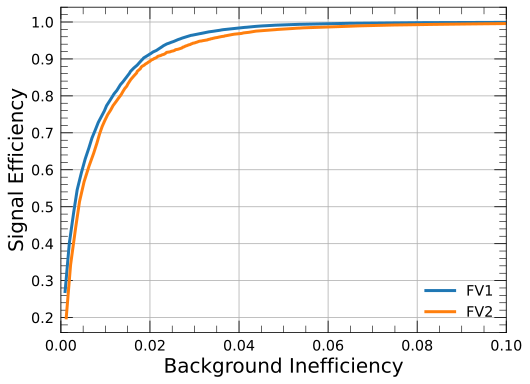

In [177]:
def GetSigEff( v_eff_sig, v_eff_bkg, certain_eff_bkg=0.01):
    from scipy.interpolate import interp1d
    v_eff_bkg = np.array(v_eff_bkg)
    v_eff_sig = np.array(v_eff_sig)
    f = interp1d(v_eff_bkg[1:], v_eff_sig[1:], kind="linear")
    eff_sig_return = f(certain_eff_bkg)
    return (certain_eff_bkg, eff_sig_return)

def GetSignalEfficiency(n0, n1,
                        label:str="", axes:plt.Axes=None,
                        ls=None,color=None, extra_label=""):
    # n0 = dir_events["PSD"][dir_events["tag"]==0]
    # n1 = dir_events["PSD"][dir_events["tag"]==1]
    certain_eff_bkg = 0.01
    if axes is None:
        axes = plt.subplot(111)
    eff_bkg = []
    eff_sig = []
    for i in range(len(n0)):
        eff_bkg.append(np.sum(n0[i:]) * 1.0 / np.sum(n0))
        eff_sig.append(np.sum(n1[i:]) * 1.0 / np.sum(n1))
    line = axes.plot(eff_bkg,eff_sig, label=label,
              ls=ls, color=color)
    if not extra_label=="":
        axes.plot(eff_bkg,eff_sig, label=extra_label,
                         ls=ls, color=line[0].get_color())

    (certain_eff_bkg, eff_sig_return) = GetSigEff(v_eff_bkg=eff_bkg, v_eff_sig=eff_sig,
                                                  certain_eff_bkg=certain_eff_bkg)
    return (eff_sig_return, line)

print("Under 1% Background Inefficiency:")
print("Signal Efficiency(FV1):",GetSignalEfficiency(dir_n0[v_keys[0]], dir_n0[v_keys[1]],label="FV1" )[0])
print("Signal Efficiency(FV2):",GetSignalEfficiency(dir_n0_FV2[v_keys[0]], dir_n0_FV2[v_keys[1]],label="FV2")[0])
plt.legend()
plt.grid()
plt.xlim(0, 0.1)
plt.xlabel("Background Inefficiency")
plt.ylabel("Signal Efficiency")
plt.savefig("./figure/ROC.png")

In [178]:
from copy import copy
dir_TMVA_file = {}
with up.open("/afs/ihep.ac.cn/users/l/luoxj/TestPSD_offline/Train_Results/train_chengjie.root") as f:
    for key_FV in ["FV1", "FV2"]:
        for key in ["Train", "Test"]:
            dir = {}
            tree_test = f[f"AtmNCRejection_{key_FV}_chengjie/{key}Tree"]
            dir["BDTG"] = np.array(tree_test[f"BDTG_{key_FV}"])
            dir["classID"] = np.array(tree_test["classID"])
            dir_TMVA_file[f"{key}_{key_FV}"] = copy(dir)
print(dir_TMVA_file)


{'Train_FV1': {'BDTG': array([ 0.9965196 , -0.999959  ,  0.9980822 , ..., -0.9984611 ,
        0.99399734,  0.82395875], dtype=float32), 'classID': array([1, 0, 1, ..., 0, 1, 1], dtype=int32)}, 'Test_FV1': {'BDTG': array([0.9463817 , 0.99133027, 0.9355155 , ..., 0.81670004, 0.8775378 ,
       0.73559225], dtype=float32), 'classID': array([1, 1, 1, ..., 1, 1, 1], dtype=int32)}, 'Train_FV2': {'BDTG': array([0.85802567, 0.9918518 , 0.9845095 , ..., 0.84180695, 0.42667708,
       0.9640718 ], dtype=float32), 'classID': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}, 'Test_FV2': {'BDTG': array([ 0.96399426,  0.99604267,  0.99536854, ..., -0.9942778 ,
       -0.92225784,  0.9945773 ], dtype=float32), 'classID': array([0, 0, 0, ..., 1, 1, 0], dtype=int32)}}


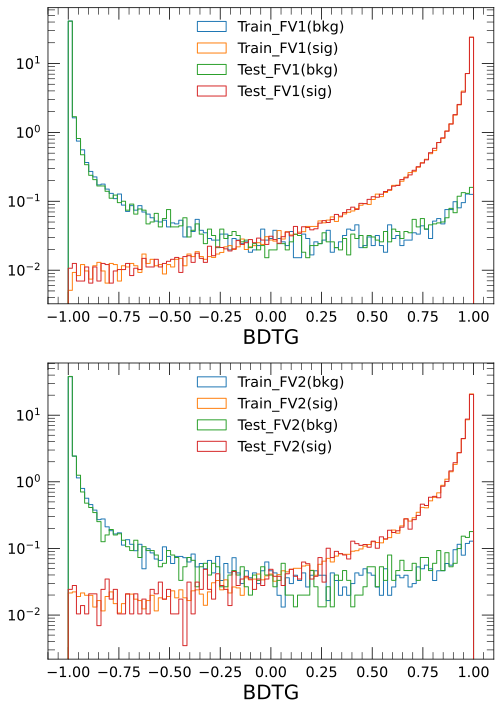

In [198]:
path_basic = "/afs/ihep.ac.cn/users/l/luoxj/scratchfs_juno_500G/TestPSD_offline/"

bins=np.linspace(-1,1,100)
fig, axes = plt.subplots(2, figsize=(8,12))
for key,dir in dir_TMVA_file.items():
    if "FV1" in key:
        ax = axes[0]
        classID_sig = 1
        classID_bkg = 0
    elif "FV2" in key:
        ax = axes[1]
        classID_bkg = 1
        classID_sig = 0
    dir_TMVA_file[key]["h_bkg"] = ax.hist(dir["BDTG"][dir["classID"]==classID_bkg], histtype="step", bins=bins, label=f"{key}(bkg)",
                                          density=True)
    dir_TMVA_file[key]["h_sig"] = ax.hist(dir["BDTG"][dir["classID"]==classID_sig], histtype="step", bins=bins, label=f"{key}(sig)",
                                          density=True)

# Prediction
# for key in dir_predict.keys():
#     n0, bins0, patches0 =axes[0].hist(dir_predict[key], bins=bins, histtype="step",
#                                           label="Predict_FV1(bkg)" if key == "atm" else "Predict_FV1(sig)" )
#     dir_n0[key] = n0
# for key in dir_predict_FV2.keys():
#     n0_FV2, bins0, patches0 =axes[1].hist(dir_predict_FV2[key], bins=bins, histtype="step",
#                                   label="Predict_FV2(bkg)" if key == "atm" else "Predict_FV2(sig)" )
#     dir_n0_FV2[key] = n0_FV2

for ax in axes:
    ax.legend(loc="upper center")
    ax.semilogy()
    ax.set_xlabel("BDTG")
fig.savefig(path_basic+"/figure/BDTG_distribution_FV1_FV2.png")
# axes[0].set_title("FV1")
# axes[1].set_title("FV2")

Train_FV1 Signal Efficiency:	0.7886	+-	0.0013
Test_FV1 Signal Efficiency:	0.7431	+-	0.0013
Train_FV2 Signal Efficiency:	0.7608	+-	0.0017
Test_FV2 Signal Efficiency:	0.6926	+-	0.0039
Predict_FV2 Signal Efficiency:	0.7365	+-	0.0016
Predict_FV1 Signal Efficiency:	0.7660	+-	0.00092


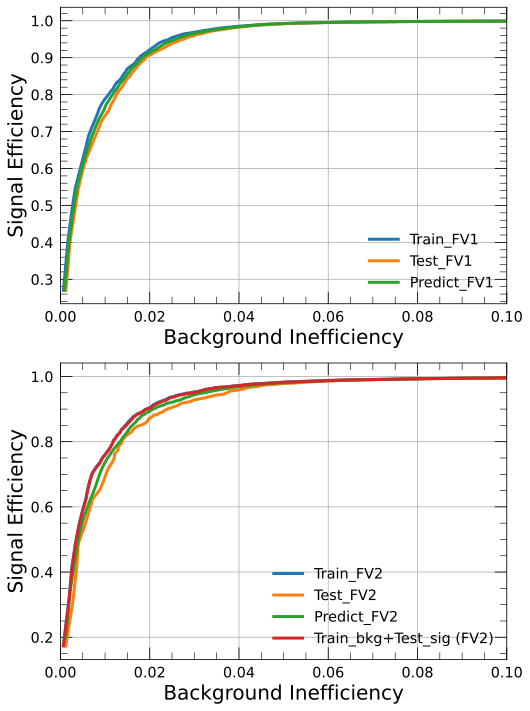

In [192]:
from collections import Counter
def GetEfficiencySigma(eff, n_events):
    relative_sigma_eff = np.sqrt(eff*(1-eff)*n_events)/n_events
    return relative_sigma_eff
fig, axes = plt.subplots(2, figsize=(8,12))
for key,dir in dir_TMVA_file.items():
    if "FV1" in key:
        ax = axes[0]
        classID_sig = 1
        classID_bkg = 0
    elif "FV2" in key:
        ax = axes[1]
        classID_bkg = 1
        classID_sig = 0
    eff_sig = GetSignalEfficiency(dir["h_bkg"][0],dir["h_sig"][0],label=f"{key}",axes=ax )[0]
    print(f"{key} Signal Efficiency:\t{eff_sig:.4f}\t+-\t{GetEfficiencySigma(eff_sig, Counter(dir['classID']==classID_sig)[True]):.2g}")
eff_predict_FV2 = GetSignalEfficiency(dir_n0_FV2[v_keys[0]], dir_n0_FV2[v_keys[1]],label="Predict_FV2",axes=axes[1])[0]
print(f"Predict_FV2 Signal Efficiency:\t{eff_predict_FV2:.4f}\t+-\t"
      f"{GetEfficiencySigma(eff_predict_FV2,len(dir_predict_FV2['DSNB'])):.2g}")
eff_predict_FV1 = GetSignalEfficiency(dir_n0[v_keys[0]], dir_n0[v_keys[1]],label="Predict_FV1",axes=axes[0])[0]
print(f"Predict_FV1 Signal Efficiency:\t{eff_predict_FV1:.4f}\t+-\t"
      f"{GetEfficiencySigma(eff_predict_FV1,len(dir_predict['DSNB'])):.2g}")

GetSignalEfficiency(dir_TMVA_file["Train_FV2"]["h_bkg"][0],
                    dir_TMVA_file["Test_FV2"]["h_sig"][0],label="Train_bkg+Test_sig (FV2)",
                    axes=axes[1])
for ax in axes:
    ax.legend()
    ax.grid()
    ax.set_xlim(0, 0.1)
    ax.set_xlabel("Background Inefficiency")
    ax.set_ylabel("Signal Efficiency")

fig.savefig(path_basic+"/figure/ROC_FV1_FV2_All.png")

In [186]:
print(Counter(dir_TMVA_file["Test_FV2"]["classID"]==1))
print(Counter(dir_TMVA_file["Train_FV2"]["classID"]==1))


Counter({False: 14252, True: 7452})
Counter({False: 60000, True: 15000})


In [ ]:
fig, axes = plt.subplots(2, figsize=(8,12))
for key,dir in dir_TMVA_file.items():
    if "FV1" in key:
        ax = axes[0]
        classID_sig = 1
        classID_bkg = 0
    elif "FV2" in key:
        ax = axes[1]
        classID_bkg = 1
        classID_sig = 0
    eff_sig = GetSignalEfficiency(dir["h_bkg"][0],dir["h_sig"][0],label=f"{key}",axes=ax )[0]
    print(f"{key} Signal Efficiency:\t{eff_sig:.4f}\t+-\t{GetEfficiencySigma(eff_sig, Counter(dir['classID']==classID_sig)[True]):.2g}")